# Comparison of data


by soniame@iadb.org

- **Google COVID-19 Mobility Report**

[Google link](https://www.google.com/covid19/mobility/)

Baseline: median value for the corresponding day of week during a 5 week period from January 3rd, 2020 to February 6th, 2020. 

- **Waze driven kilometers** driven kilometers percent change from baseline. 

[Waze link](https://www.waze.com/covid19)

Baseline: average value for the corresponding day of week during a 2 week period from February 11th, 2020 to February 25th, 2020.

In [26]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
home = str(Path.home())

import sys
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

from copy import deepcopy
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
import yaml
import matplotlib.pyplot as plt 
import datetime

import warnings
warnings.filterwarnings('ignore')

# Plotting
import plotly
import plotly.graph_objs as go
import cufflinks as cf
plotly.offline.init_notebook_mode(connected=True)

def iplottitle(title, width=40):
    return '<br>'.join(textwrap.wrap(title, width))
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format
p9.theme_set(p9.theme_linedraw()) # default theme

# Setting cufflinks
import textwrap
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import yaml
from jinja2 import Template
cf.themes.THEMES['custom'] = yaml.load(open('cufflinks_template.yaml', 'r'))

# Manipulation 
from siuba import *

In [27]:
from src import utils
from datetime import datetime
conn = utils.connect_athena(path='../configs/athena.yaml')

In [67]:
iso_codes = pd.read_sql_query("""
select 
    distinct country_iso_code, country_name
from spd_sdv_waze_corona.prod_daily_daily_index
""", conn)

In [68]:
len(iso_codes.country_iso_code.to_list())

20

In [69]:
iso_codes.sort_values('country_iso_code')

,country_iso_code,country_name
12,AR,Argentina
8,BB,Barbados
19,BO,Bolivia
0,BR,Brazil
2,CL,Chile
10,CO,Colombia
7,CR,Costa Rica
18,DO,Dominican Republic
13,EC,Ecuador
9,GT,Guatemala


## Load data (country level)

Loading data for latinamerican countries. 

### Waze Dashboard

In [73]:
df_dash = pd.read_sql_query("""
select 
    *,
    (date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e')) as date
from spd_sdv_waze_corona.prod_daily_daily_index
where region_slug like '%country%'
""", conn)
# Bolivia

In [74]:
tab = (df_dash 
 >> group_by('country_iso_code', 'country_name', 'region_slug')
 >> summarize(min_date = _.date.min(),
             max_date = _.date.max(),
             n_obs = _.date.count())
 >> ungroup()
)
#tab.to_csv('~/private/projects/google_mob_country_list.csv')
tab

,country_iso_code,country_name,region_slug,min_date,max_date,n_obs
0,AR,Argentina,country_argentina,2020-03-09,2021-02-16,345
1,BB,Barbados,country_barbados,2020-03-09,2021-02-16,345
2,BR,Brazil,country_brazil,2020-03-09,2021-02-16,345
3,CL,Chile,country_chile,2020-03-09,2021-02-16,345
4,CO,Colombia,country_colombia,2020-03-09,2021-02-16,345
5,CR,Costa Rica,country_costa_rica,2020-03-09,2021-02-16,345
6,DO,Dominican Republic,country_dominican_republic,2020-03-09,2021-02-16,345
7,EC,Ecuador,country_ecuador,2020-03-09,2021-02-16,345
8,GT,Guatemala,country_guatemala,2020-03-09,2021-02-16,345
9,HN,Honduras,country_honduras,2020-03-09,2021-02-16,345


In [78]:
print(len(iso_codes.country_iso_code.to_list()))
#df_dash.head()
print(len(df_dash.country_iso_code.unique())) # Bolivia is missing
df_dash.sort_values('country_iso_code').country_iso_code.unique()

20
19


array(['AR', 'BB', 'BR', 'CL', 'CO', 'CR', 'DO', 'EC', 'GT', 'HN', 'JM',
       'MX', 'NI', 'PA', 'PE', 'PY', 'SV', 'TT', 'UY'], dtype=object)

In [80]:
len(df_dash.country_name.unique())
df_dash.country_name.unique()

array(['Mexico', 'Trinidad and Tobago', 'Panama', 'Brazil', 'Honduras',
       'Costa Rica', 'Chile', 'Argentina', 'El Salvador', 'Peru',
       'Uruguay', 'Guatemala', 'Colombia', 'Ecuador', 'Barbados',
       'Dominican Republic', 'Paraguay', 'Nicaragua', 'Jamaica'],
      dtype=object)

In [92]:
#df_dash.columns.tolist()


### Waze driven km

In [241]:
df_waze = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/mobility/Waze _ COVID-19 Impact Dashboard_Country-Level Data_Table.csv")
df_waze.columns = ['date', 'country', 'pc_driven_miles']
df_waze['date'] = df_waze.date.apply(lambda x : datetime.strptime(x, '%b %d, %Y'))
df_waze['exists'] = df_waze.country.isin([ 'Argentina','Brazil', 'Chile', 'Colombia', 'Costa Rica',  
                                          'Ecuador', 'Guatemala',  'Mexico',  'Peru', 'Uruguay']) 
df_waze = df_waze.siu_filter(_.exists).siu_mutate(pc_driven_miles=100*_.pc_driven_miles)      

df_waze.head()

,date,country,pc_driven_miles,exists
1,2021-02-17,Peru,-44.0,True
9,2021-02-17,Mexico,-32.0,True
14,2021-02-17,Ecuador,-25.0,True
25,2021-02-17,Guatemala,-15.0,True
26,2021-02-17,Colombia,-12.0,True


Missing countries: Panama, Honduras, Trinidad and Tobago, Dominican Republic, Paraguay, Barbados, El Salvador, Jamaica, Nicaragua

In [242]:
tab = (df_waze 
 >> group_by('country')
 >> summarize(min_date = _.date.min(),
             max_date = _.date.max(),
             n_obs = _.date.count())
 >> ungroup()
)
#tab.to_csv('~/private/projects/google_mob_country_list.csv')
tab

,country,min_date,max_date,n_obs
0,Argentina,2020-03-01,2021-02-17,354
1,Brazil,2020-03-01,2021-02-17,354
2,Chile,2020-03-01,2021-02-17,354
3,Colombia,2020-03-01,2021-02-17,354
4,Costa Rica,2020-03-01,2021-02-17,354
5,Ecuador,2020-03-01,2021-02-17,354
6,Guatemala,2020-03-01,2021-02-17,354
7,Mexico,2020-03-01,2021-02-17,354
8,Peru,2020-03-01,2021-02-17,354
9,Uruguay,2020-03-01,2021-02-17,354


In [243]:
print('Countries: ' + str(len(df_waze.country.unique())) )
df_waze.country.unique()

Countries: 10


array(['Peru', 'Mexico', 'Ecuador', 'Guatemala', 'Colombia', 'Costa Rica',
       'Chile', 'Brazil', 'Argentina', 'Uruguay'], dtype=object)

### Google mobility

In [148]:
df_goo = pd.read_csv("~/shared/spd-sdv-omitnik-waze/corona/mobility/Global_Mobility_Report.csv")  
df_goo['inregion']=df_goo.country_region_code.isin(iso_codes.country_iso_code.to_list())
df_goo['date'] = df_goo.date.apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))
df_goo = df_goo \
    .siu_filter(_.inregion) \
    .siu_filter( _.sub_region_1.isnull(), _.metro_area.isnull())
print(df_goo.shape)

(7211, 15)


In [149]:
tab = (df_goo 
 >> group_by('country_region_code', 'country_region')
 >> summarize(min_date = _.date.min(),
             max_date = _.date.max(),
             n_obs = _.date.count())
 >> ungroup()
)
tab

,country_region_code,country_region,min_date,max_date,n_obs
0,AR,Argentina,2020-02-15,2021-02-09,361
1,BB,Barbados,2020-02-15,2021-02-09,361
2,BO,Bolivia,2020-02-15,2021-02-09,361
3,BR,Brazil,2020-02-15,2021-02-09,361
4,CL,Chile,2020-02-15,2021-01-31,352
5,CO,Colombia,2020-02-15,2021-02-09,361
6,CR,Costa Rica,2020-02-15,2021-02-09,361
7,DO,Dominican Republic,2020-02-15,2021-02-09,361
8,EC,Ecuador,2020-02-15,2021-02-09,361
9,GT,Guatemala,2020-02-15,2021-02-09,361


In [150]:
print(len(df_goo.country_region_code.unique()))
df_goo.country_region_code.unique()

20


array(['AR', 'BB', 'BO', 'BR', 'CL', 'CO', 'CR', 'DO', 'EC', 'GT', 'HN',
       'JM', 'MX', 'NI', 'PA', 'PE', 'PY', 'SV', 'TT', 'UY'], dtype=object)

In [153]:
df_goo.dtypes
df_goo.columns

Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'metro_area', 'iso_3166_2_code', 'census_fips_code', 'date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'inregion'],
      dtype='object')

In [116]:
#df_dash.add_suffix('_col').head()

## Country comparison

In [244]:
df = (df_dash \
     .siu_select('region_slug', 'country_name', 'country_iso_code', 'date', 'tcp') 
 >> left_join(_, 
          df_waze \
              .siu_select('country', 'date', 'pc_driven_miles') \
              .siu_rename(country_name='country'), 
              on=['country_name', 'date']) 
 >> left_join(_, 
          df_goo \
              .siu_select('country_region_code', 'date', 'transit_stations_percent_change_from_baseline') \
              .siu_rename(country_iso_code='country_region_code',
                          transit='transit_stations_percent_change_from_baseline'), 
              on=['country_iso_code', 'date']) 
 >> gather('measure', 'value', _["tcp":"transit"]) 
)
df.dtypes
df.head(2)

,region_slug,country_name,country_iso_code,date,measure,value
0,country_mexico,Mexico,MX,2020-12-03,tcp,47.036628
1,country_mexico,Mexico,MX,2020-10-08,tcp,10.272689


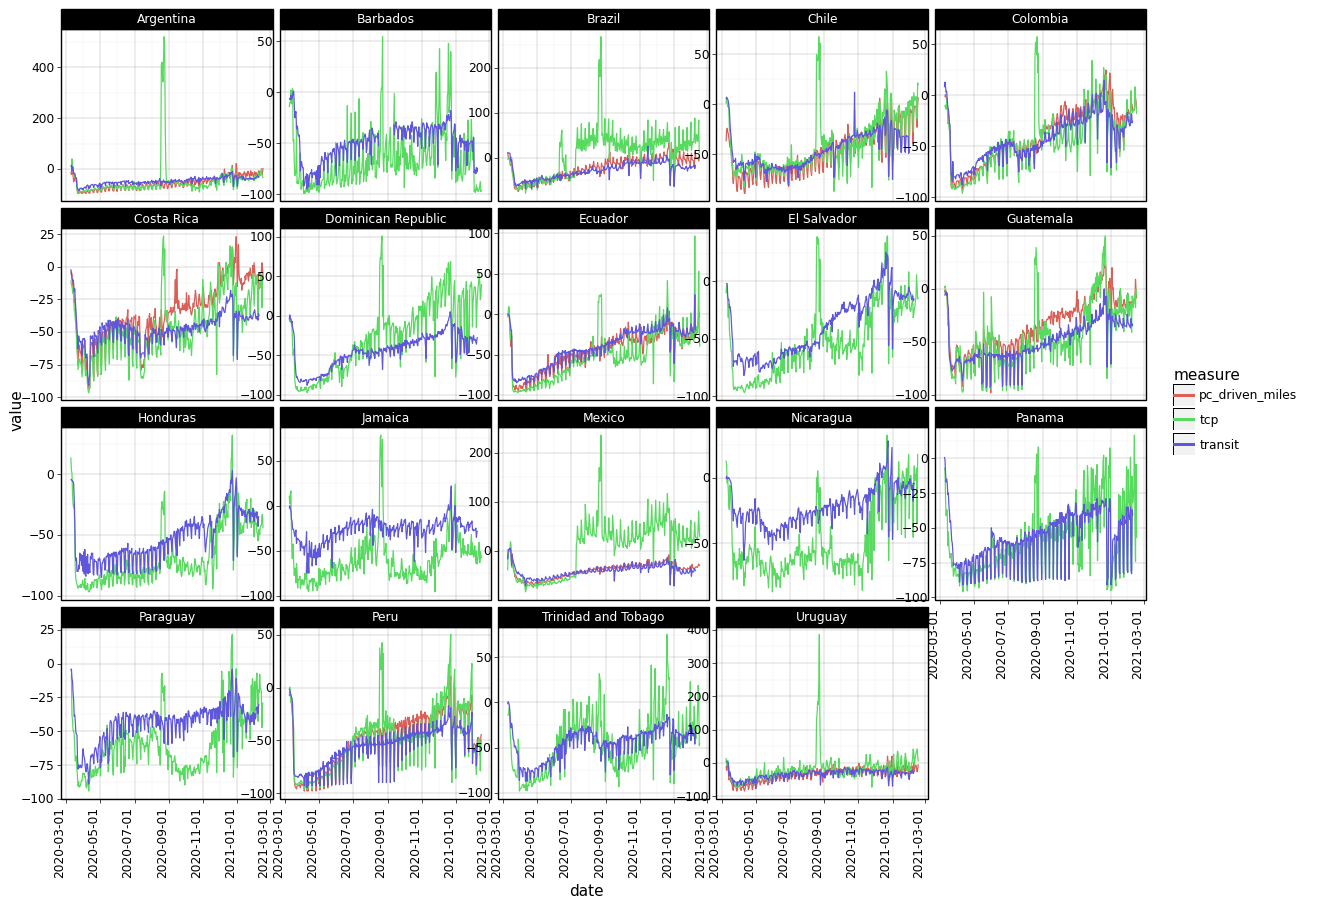

<ggplot: (8783621109217)>

In [248]:

(p9.ggplot(df, 
           p9.aes(x='date', y ='value', color = 'measure')) 
 + p9.geom_line()
 + p9.facet_wrap('country_name', scales='free_y') 
 + p9.theme(figure_size = (14, 10),
            axis_text_x=p9.element_text(rotation=90, hjust=1))
) 

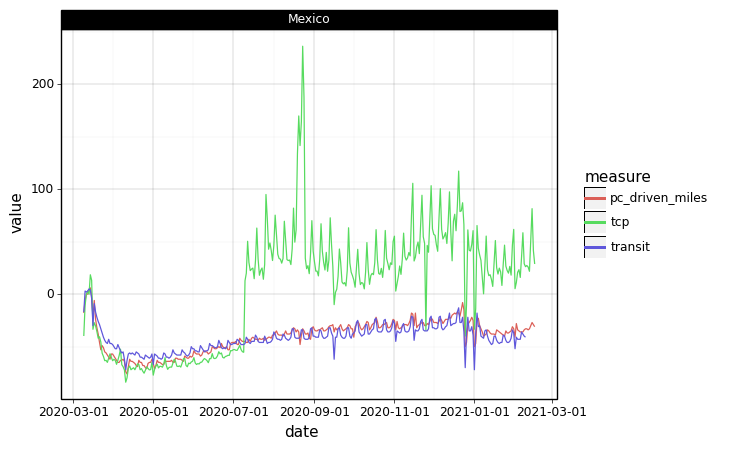

<ggplot: (8783606848461)>

In [249]:
(p9.ggplot(df.siu_filter(_.country_name=='Mexico'), 
           p9.aes(x='date', y ='value', color = 'measure')) 
 + p9.geom_line()
 + p9.facet_wrap('country_name')
) 

### Plots per data source

In [250]:
df_goo[['date', 'transit_stations_percent_change_from_baseline', 'country_region']] \
    .pivot(index='date', columns='country_region', values='transit_stations_percent_change_from_baseline') \
    .iplot(
    #theme='custom',
    yTitle='% Change',
    title='Google mobility - PC Transit stations'
)

In [251]:
df_dash[['date', 'tcp', 'region_slug']] \
    .pivot(index='date', columns='region_slug', values='tcp') \
    .iplot(
    #theme='custom',
    yTitle='% Change',
    title='Waze IDB dashboard - TCP'
)

In [252]:
df_waze[['date', 'pc_driven_miles', 'country']] \
    .pivot(index='date', columns='country', values='pc_driven_miles') \
    .iplot(
    #theme='custom',
    yTitle='% Change',
    title='Waze public - PC driven miles'
)